In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, accuracy_score
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model


In [2]:
# --- Step 1: Load image paths and labels ---
base_dir = '/kaggle/input/skinv1/CancerSkin'
categories = ['Normal','Cancer']
image_paths = []
labels = []
for category in categories:
    category_path = os.path.join(base_dir, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_paths.append(os.path.join(category_path, filename))
            labels.append(category)


In [3]:
# Create train-test split  
X_train, X_test, y_train, y_test = train_test_split(  
    image_paths,  
    labels,  
    test_size=0.2,  # 20% of data will be used as test set  
    random_state=42,  # For reproducibility 
) 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Encoding train labels
y_test = label_encoder.transform(y_test)  # Encoding test labels


**Thực hiện phân loại ảnh**

In [4]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7065 - loss: 0.7824 - val_accuracy: 0.9400 - val_loss: 0.1084
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.9696 - loss: 0.0903 - val_accuracy: 0.9800 - val_loss: 0.0635
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9750 - loss: 0.0720 - val_accuracy: 1.0000 - val_loss: 0.0340
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9893 - loss: 0.0360 - val_accuracy: 0.9600 - val_loss: 0.0902
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9963 - loss: 0.0198 - val_accuracy: 0.9800 - val_loss: 0.0340
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9937 - loss: 0.0145 - val_accuracy: 0.9600 - val_loss: 0.0463
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 0.9800 - val_loss: 0.0619
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 0.9800 - val_loss: 0.0837
2/

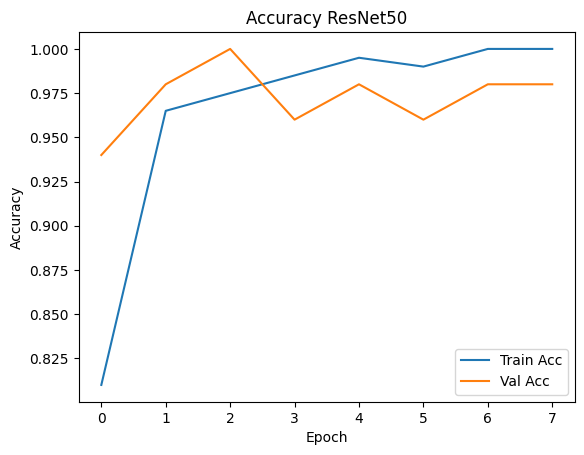

In [10]:

# Step 1: Hàm đọc và resize ảnh + chuẩn hóa theo chuẩn ResNet50
def load_images_resnet(image_paths, target_size=(224, 224)):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, target_size)
        img = preprocess_input(img)  # Dùng hàm chuẩn hóa từ ResNet
        images.append(img)
    return np.array(images)

# Step 2: Create train-test split  
X_train, X_test, y_train, y_test = train_test_split(  
    image_paths,  
    labels,  
    test_size=0.2,  # 20% of data will be used as test set  
    random_state=42,  # For reproducibility 
) 

# Step 3:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Encoding train labels
y_test = label_encoder.transform(y_test)  # Encoding test labels

# Step 4: Convert to categorical (one-hot encoding)
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Step 5: Áp dụng cho train/test
x_train = load_images_resnet(X_train)
x_test = load_images_resnet(X_test)

# --- Step 6: Build ResNet50 model ---
# Load ResNet50 pre-trained, không bao gồm lớp output gốc
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Không cho học lại trọng số gốc

# Thêm các lớp phía trên (custom head)
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)  # Giảm overfitting
predictions = layers.Dense(num_classes, activation='softmax')(x)

# Gộp thành model hoàn chỉnh
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#model.summary()

# --- Step 7: Train the model ---
history = model.fit(x_train, y_train, epochs=8, validation_data=(x_test, y_test))

# --- Step 8: Evaluate the model ---
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\n🎯 Test Accuracy ResNet50: {test_acc:.4f}")

# Step 9: Vẽ biểu đồ training/validation accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy ResNet50')
plt.legend()
plt.savefig('ResNet50_train.png')
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


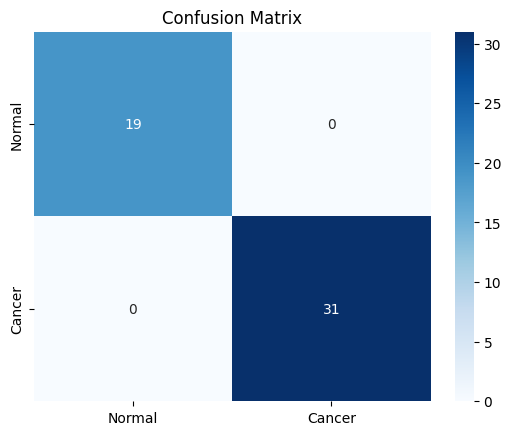

              precision    recall  f1-score   support

      Cancer       1.00      1.00      1.00        19
      Normal       1.00      1.00      1.00        31

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [6]:
import seaborn as sns
# Step 1: Predict on the test set
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Step 2: Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Step 3: Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.title("Confusion Matrix")
plt.savefig('Proposed_Confusion.png')
plt.show()


# Báo cáo phân loại
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))
